In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
DATA_STORE = '../../../Data-Daily/india_asset.h5'

In [3]:
with pd.HDFStore(DATA_STORE) as store:
    nifty50_m = (store['/nse/nifty50/metadata'])
nifty50_m.head(3)

,key_0,Symbol,Company Name,Industry,Series,country,name,full_name,currency,symbol
isin,,,,,,,,,,
INE742F01042,INE742F01042,ADANIPORTS,Adani Ports and Special Economic Zone Ltd.,SERVICES,EQ,india,Adani,Adani Port and Special Economic Zone Ltd,INR,APSE
INE021A01026,INE021A01026,ASIANPAINT,Asian Paints Ltd.,CONSUMER GOODS,EQ,india,Asian Paints,Asian Paints Ltd.,INR,ASPN
INE238A01034,INE238A01034,AXISBANK,Axis Bank Ltd.,FINANCIAL SERVICES,EQ,india,AXIS Bank,AXIS Bank Ltd,INR,AXBK


In [4]:
tickers = list(nifty50_m[nifty50_m.Industry=='FINANCIAL SERVICES'].symbol)
print(tickers)

['AXBK', 'BJFN', 'BJFS', 'HDBK', 'HDFL', 'HDFC', 'ICBK', 'INBK', 'KTKM', 'SBIL', 'SBI']


In [5]:
# get the ticker data from data store
columns = ['close','high','low','open','volume']
with pd.HDFStore(DATA_STORE) as store:
    prices = store['/ind/nifty500_investing/prices'].loc[idx[tickers, :], columns]
prices.head(3)

close   high   low   open   volume
ticker date                                          
AXBK   2003-12-29  27.43  30.64  26.8  30.64  2000585
       2003-12-30  27.38  28.60  27.0  27.80  3135540
       2003-12-31  27.13  27.80  27.0  27.80  1077130

In [6]:
days = 3024

In [7]:
# remove tickers where we have less than 10 years of data.
min_obs = days
nobs = prices.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index

prices = prices.loc[idx[keep,:], :]
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 44222 entries, ('AXBK', Timestamp('2003-12-29 00:00:00')) to ('SBI', Timestamp('2021-02-23 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   44222 non-null  float64
 1   high    44222 non-null  float64
 2   low     44222 non-null  float64
 3   open    44222 non-null  float64
 4   volume  44222 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 2.0+ MB


In [8]:
# final tickers list
tickers = list(prices.index.get_level_values('ticker').unique())
print(len(tickers))
print(tickers)

9
['AXBK', 'BJFN', 'BJFS', 'HDBK', 'HDFC', 'ICBK', 'INBK', 'KTKM', 'SBI']


In [9]:
# unstack and take close price
close = prices.unstack('ticker')['close'].sort_index()
close = close.dropna()
close = close.tail(days)
close.head(2)

ticker,AXBK,BJFN,BJFS,HDBK,HDFC,ICBK,INBK,KTKM,SBI
date,,,,,,,,,
2008-12-08,90.39,6.85,102.96,89.60,302.39,67.27,32.2,88.20,116.88
2008-12-10,92.56,6.73,107.43,92.17,323.71,72.74,31.6,90.41,118.91


In [10]:
# train test split 
train_close, test_close = train_test_split(close, test_size=0.2, shuffle=False)

In [11]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

ticker,AXBK,BJFN,BJFS,HDBK,HDFC,ICBK,INBK,KTKM,SBI
date,,,,,,,,,
2008-12-08,90.39,6.85,102.96,89.60,302.39,67.27,32.20,88.20,116.88
2008-12-10,92.56,6.73,107.43,92.17,323.71,72.74,31.60,90.41,118.91
2018-09-10,651.75,2615.65,6347.45,1018.31,1883.55,332.90,1829.15,1223.35,284.85
2018-09-11,650.15,2600.75,6362.15,997.98,1868.05,326.55,1826.50,1206.40,282.60


Text(0.5, 1.0, 'Assets Correlation Matrix')

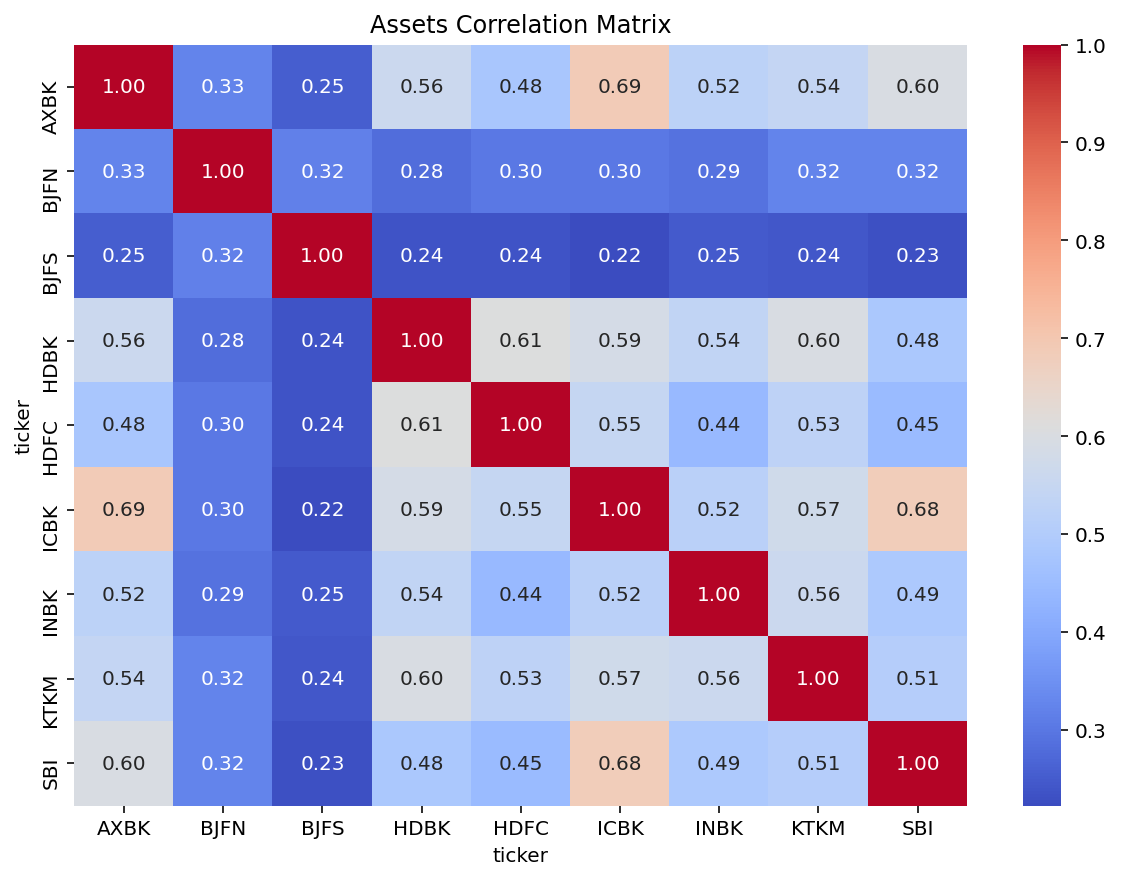

In [12]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
# plt.savefig('images/chart1', dpi=300)

In [13]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('HDBK', 'HDFC'), ('HDFC', 'INBK'), ('HDFC', 'KTKM'), ('ICBK', 'INBK'), ('INBK', 'KTKM')]


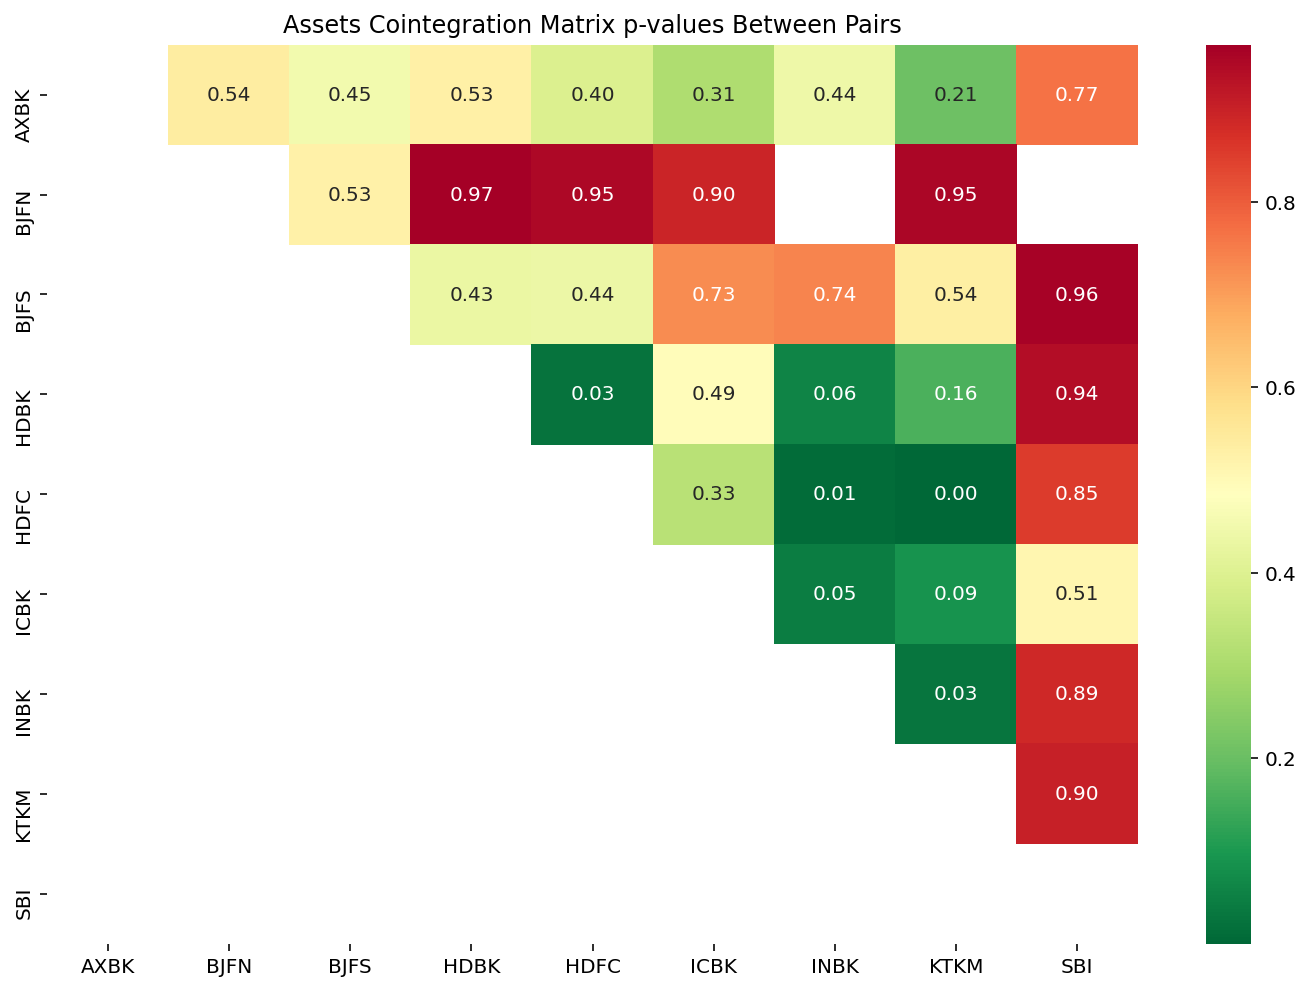

In [14]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.98))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
# plt.savefig('images/chart2', dpi=300) 

In [15]:
# final pair to test strategy
asset1 = 'HDFC'
asset2 = 'KTKM'

In [16]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train[asset1] = train_close[asset1]
train[asset2] = train_close[asset2]

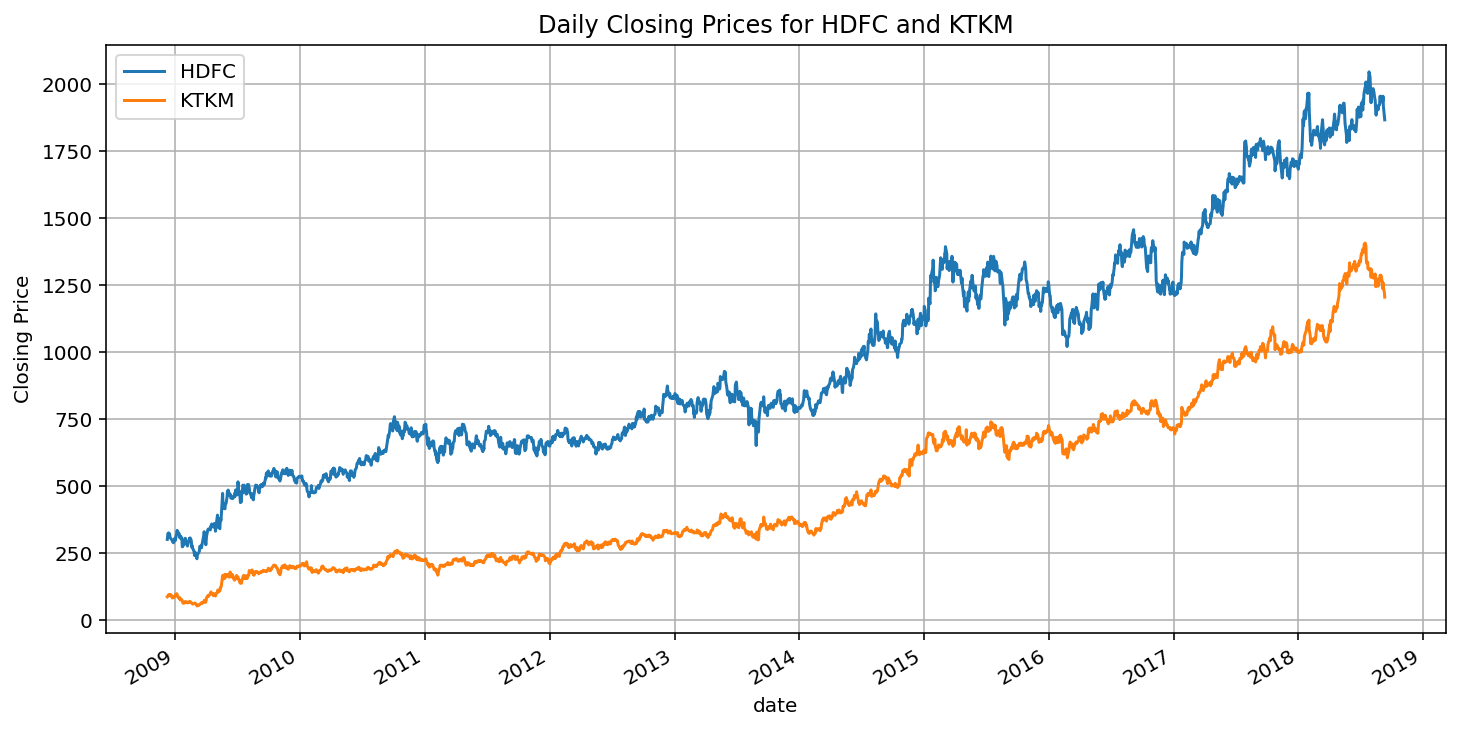

In [17]:
# visualize closing prices
ax = train[[asset1,asset2]].plot(figsize=(12, 6), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
ax.grid(True);
# plt.savefig('images/chart3', dpi=300) 

In [18]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [19]:
score, pvalue, _ = coint(train[asset1], train[asset2])
print(pvalue)

0.00018251342726630446


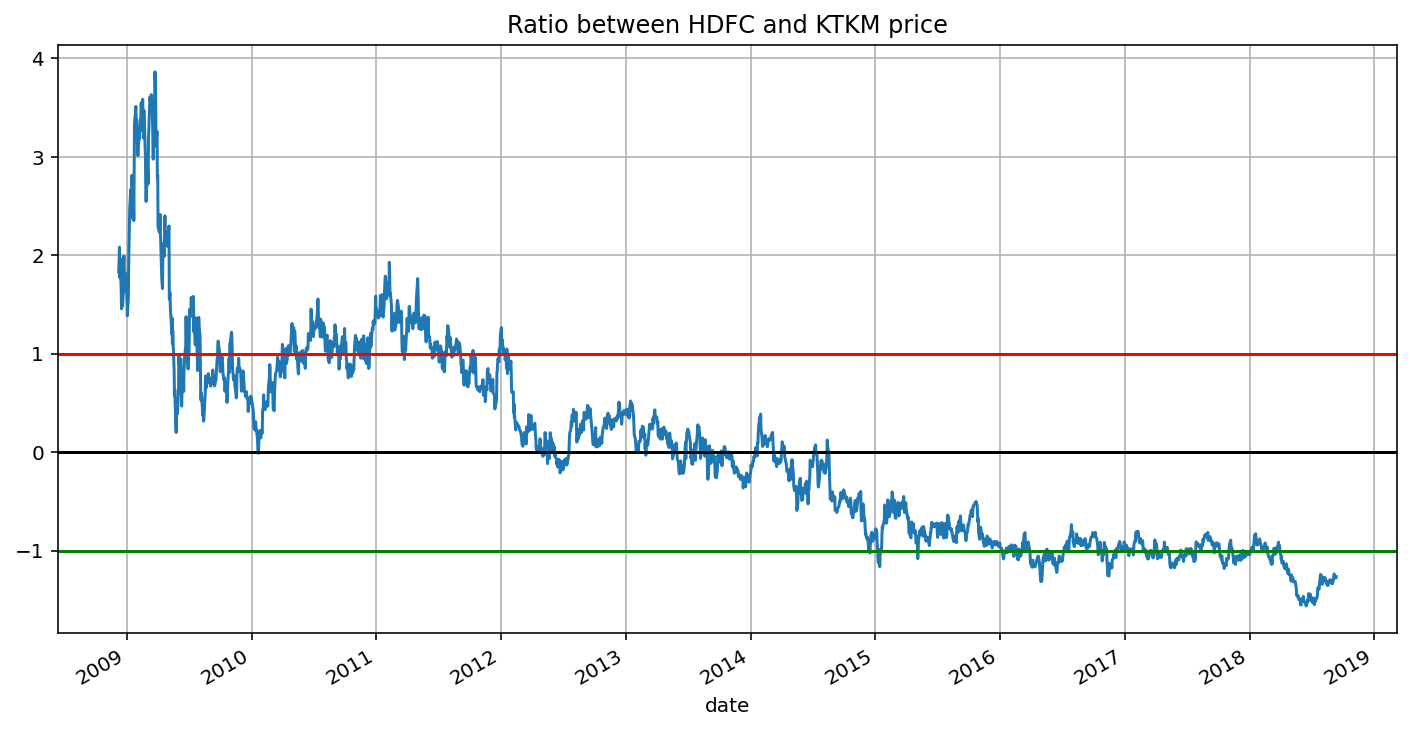

In [20]:
ratios = train[asset1] / train[asset2]
zscore(ratios).plot(figsize=(12,6))
plt.axhline(zscore(ratios).mean(),color="black")
plt.axhline(1.0, color="red")
plt.axhline(-1.0, color="green")
plt.title(f"Ratio between {asset1} and {asset2} price")
plt.grid(True)

### Test

In [21]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals[asset1] = test_close[asset1] 
signals[asset2] = test_close[asset2]
ratios = signals[asset1] / signals[asset2]

In [22]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [23]:
# create signal - short if z-score is greater than upper limit else long
signals[f'sig_{asset1}'] = 0
signals[f'sig_{asset1}'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [24]:
# we take the first order difference to obtain portfolio position in that stock
signals[f'pos_{asset1}'] = signals[f'sig_{asset1}'].diff()
signals[f'sig_{asset2}'] = -signals[f'sig_{asset1}']
signals[f'pos_{asset2}'] = signals[f'sig_{asset2}'].diff()

In [25]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

,HDFC,KTKM,z,z upper limit,z lower limit,sig_HDFC,pos_HDFC,sig_KTKM,pos_KTKM
date,,,,,,,,,
2018-09-12,1877.80,1230.40,1.072459,1.0,-1.0,-1,NaN,1,NaN
2018-09-14,1925.45,1239.55,1.339599,1.0,-1.0,-1,0.0,1,0.0
2018-09-17,1878.85,1230.40,1.080848,1.0,-1.0,-1,0.0,1,0.0
2021-02-19,2741.30,1938.75,-0.030657,1.0,-1.0,0,0.0,0,0.0
2021-02-22,2651.95,1949.60,-0.558524,1.0,-1.0,0,0.0,0,0.0
2021-02-23,2629.00,1874.00,-0.139484,1.0,-1.0,0,0.0,0,0.0


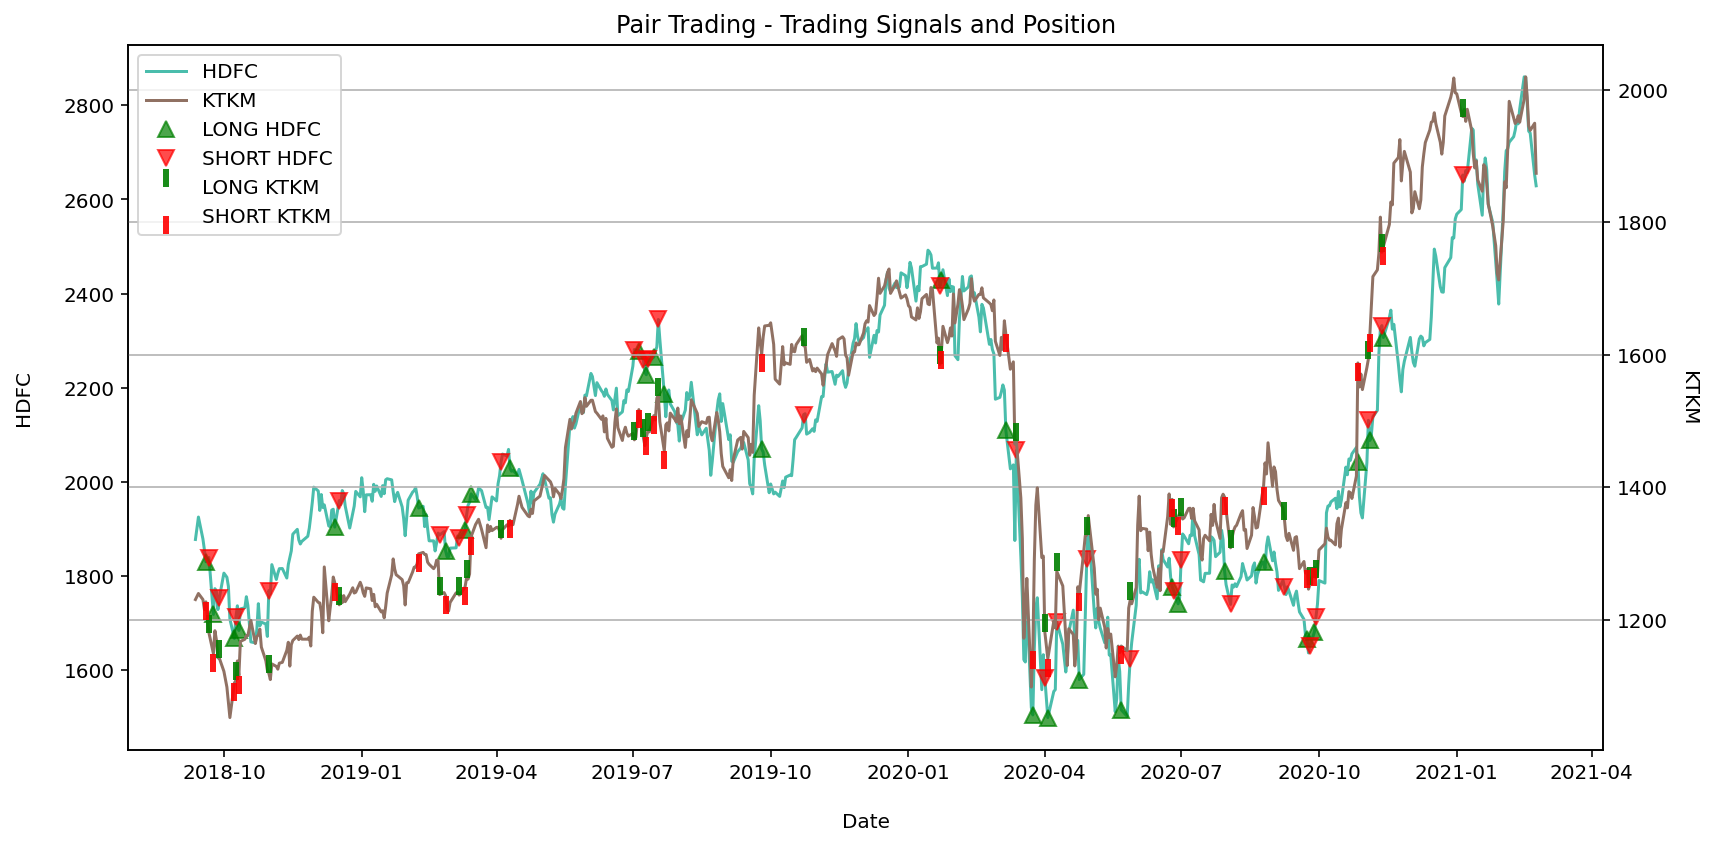

In [26]:
# visualize trading signals and position
fig=plt.figure(figsize=(12,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals[asset1], c='#4abdac')
l2, = bx2.plot(signals[asset2], c='#907163')

u1, = bx.plot(signals[asset1][signals[f'pos_{asset1}'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals[asset1][signals[f'pos_{asset1}'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals[asset2][signals[f'pos_{asset2}'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals[asset2][signals[f'pos_{asset2}'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('Date')
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
# plt.savefig('images/chart7', dpi=300);

### Portfolio Profit and Loss Calculation

In [27]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals[asset1])
positions2 = initial_capital// max(signals[asset2])

In [28]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio[asset1] = signals[asset1]
portfolio['holdings1'] = signals[f'pos_{asset1}'].cumsum() * signals[asset1] * positions1
portfolio['cash1'] = initial_capital - (signals[f'pos_{asset1}'] * signals[asset1] * positions1).cumsum()
portfolio[f'total {asset1}'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio[f'total {asset1}'].pct_change()
portfolio[f'pos_{asset1}'] = signals[f'pos_{asset1}']

In [29]:
# pnl for the 2nd asset
portfolio[asset2] = signals[asset2]
portfolio['holdings2'] = signals[f'pos_{asset2}'].cumsum() * signals[asset2] * positions2
portfolio['cash2'] = initial_capital - (signals[f'pos_{asset2}'] * signals[asset2] * positions2).cumsum()
portfolio[f'total {asset2}'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio[f'total {asset2}'].pct_change()
portfolio[f'pos_{asset2}'] = signals[f'pos_{asset2}']

In [30]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio[f'total {asset1}'] + portfolio[f'total {asset2}']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

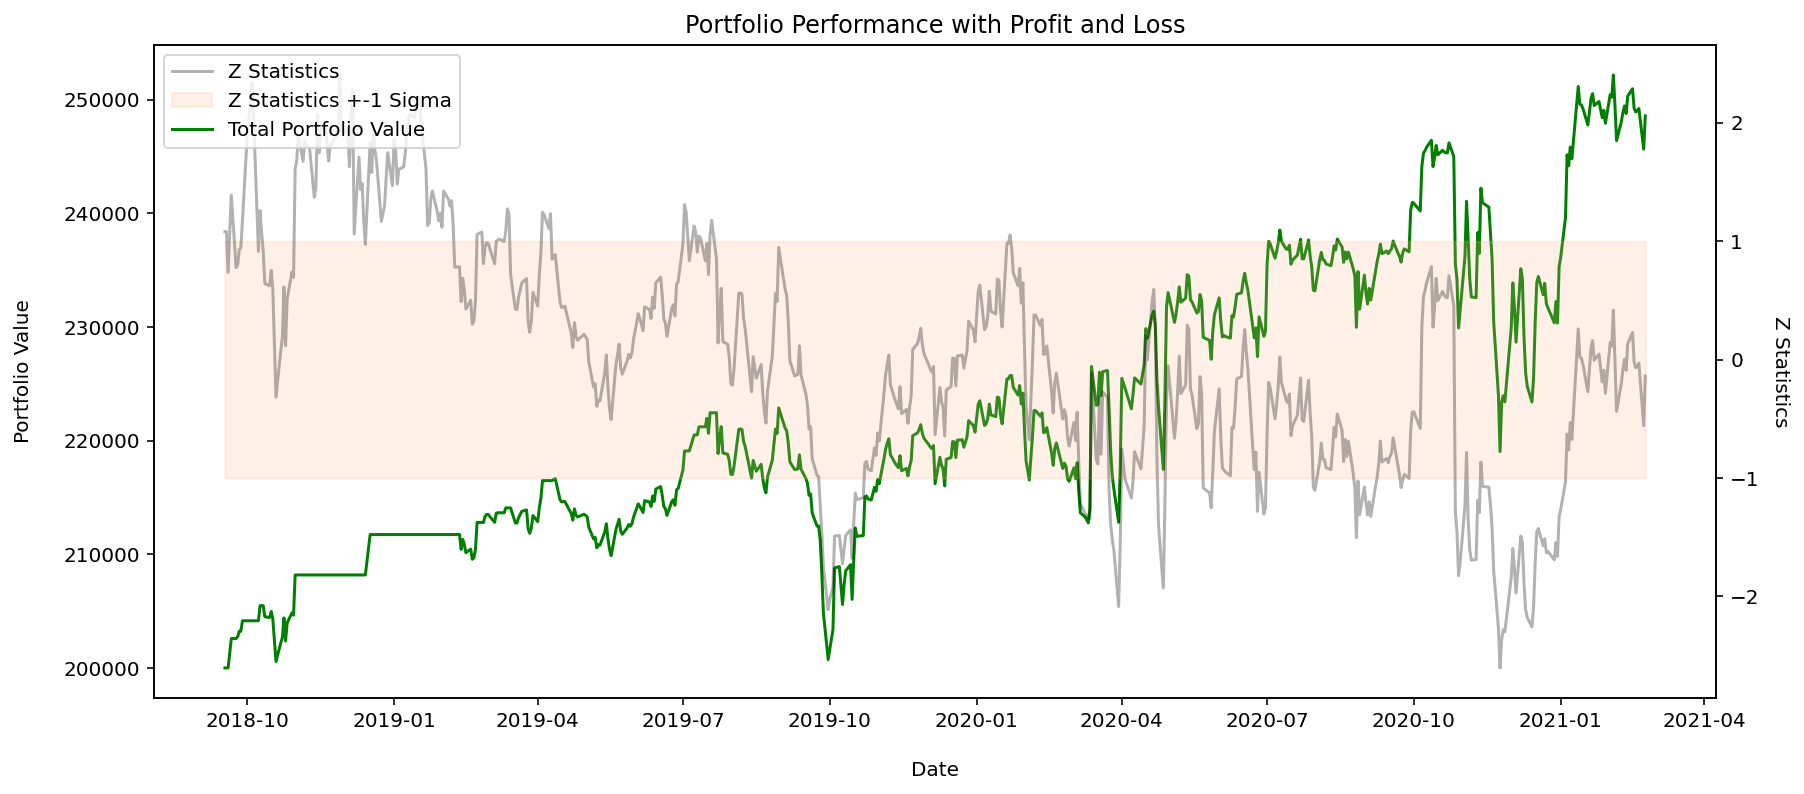

In [31]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
# plt.savefig('images/chart8', dpi=300);

In [32]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
delta = (portfolio.index[-1] - portfolio.index[0]).days
print('Number of days = ', delta)

Number of days =  890


In [33]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 45.272%


In [34]:
signals.tail()

,HDFC,KTKM,z,z upper limit,z lower limit,sig_HDFC,pos_HDFC,sig_KTKM,pos_KTKM
date,,,,,,,,,
2021-02-17,2805.35,1989.45,-0.068394,1.0,-1.0,0,0.0,0,0.0
2021-02-18,2745.15,1945.45,-0.059072,1.0,-1.0,0,0.0,0,0.0
2021-02-19,2741.30,1938.75,-0.030657,1.0,-1.0,0,0.0,0,0.0
2021-02-22,2651.95,1949.60,-0.558524,1.0,-1.0,0,0.0,0,0.0
2021-02-23,2629.00,1874.00,-0.139484,1.0,-1.0,0,0.0,0,0.0
